In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats import randint
from statistics import mean

First, we will create an array which represents the roulette board. The array will be 3 x 12, just like a standard roulette board, with each entry corresponding to a single number. We will be recreating a European roulette board since the odds are most favorable to the bettor. 0 will not be included in this board since it is a special 'green' tile.

In [2]:
# assign colors to entries in array
board = []

for i in range(1, 13):
    col = []
    for j in range(1, 4):
        n = 3 * (i - 1) + j
        col.append(n)
    board.append(col)

In [3]:
# transpose array to the standard horizontal orientation
board = np.array(board).T

In [4]:
# define function to get color of given number, black is 0
def get_color(x):
        tup = divmod(x-1, 3)
        i = tup[0] + 1
        j = tup[1] + 1
        if j == 1:
            pair = divmod(i-1, 2)[0] + 1
            if pair % 3 == 0:
                c = (i - 1) % 2
            else:
                c = i % 2
        elif j == 2:
            if i % 3 == 2:
                c = 1.0
            else:
                c = 0.0
        else:
            if (i + 1) % 3 == 0:
                c = 0.0
            else:
                c = 1.0

        return float(c)

In [5]:
# define custom color generator
class RouletteColorNorm(colors.Normalize):
    
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.array([list(map(get_color, x)) for x in value])
    
    def inverse(self, value):
        return None
    
norm = RouletteColorNorm()

In [6]:
# create discrete colormap
cmap = colors.ListedColormap(['black', 'red'])

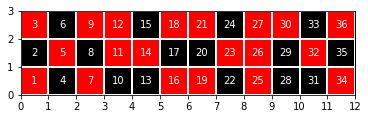

In [7]:
# display board - for some reason 11 and 26 don't display properly, but they are black
fig, ax = plt.subplots()

ax.imshow(board, cmap = cmap, origin='lower', norm=norm)

ax.set_xticks(np.arange(-.5, 12, 1))
ax.set_yticks(np.arange(-.5, 3, 1))
ax.set_xticklabels(np.arange(0, 13, 1))
ax.set_yticklabels(np.arange(0, 4, 1))

ax.grid(color='w', linestyle='-', linewidth=2)

for (j,i),label in np.ndenumerate(board):
    ax.text(i,j,label,ha='center',va='center', color='w')

Next, we will create a random number generator to simulate a spin of the roulette wheel. Assuming a completely fair wheel, each of the 37 numbers on the wheel, 0 to 36, are equally likely. Thus, we will simulate a discrete uniform random variable.

In [8]:
# create simulated wheel
wheel = randint(low=0, high=37)

In [9]:
# function to simulate spinning wheel n times
def spin_wheel(n=1):
    results = wheel.rvs(size=n)
    return results

Now, let's consider our betting options. The simplest bet in roulette is "straight up" - when you bet on a single number. It's payout is 35:1, meaning if you bet 1 dollar and win, you will receive 35 dollars plus the initial dollar you bet. Using this information, plus our previous knowledge about the probability of landing on each number, we can calculate the expected payout of the bet.

In [10]:
(35) * (1/37) + (-1) * (36/37)

-0.027027027027026973

We can confirm this in simulations by defining a function which calculates the payouts of bets for a series of spins.

In [11]:
# function to calculate payouts for straight up bets
def simple_payout(sims, bets):
    payouts = []
    assert len(sims) == len(bets)
    for i in range(len(sims)):
        if sims[i] == bets[i]:
            payouts.append(35)
        else:
            payouts.append(-1)
    return payouts

In [12]:
# function to generate constant straight up bets
def generate_bets(n, k):
    return [k] * n

In [17]:
# calculate the average payout of 10,000 straight up bets on 13
mean(simple_payout(spin_wheel(10000), generate_bets(10000, 13)))

-0.028

From the simulations above, we have confirmed the accuracy of our caclulations. Now, we will compare the expected payouts of all possible bets. Additional bets include "split" (two adjacent numbers), "street" (row of three numbers), "corner" (square of four numbers), "double street" (two adjacent rows), odd or even, low or high, red or black, column, and dozens.

In [18]:
# data frame of bets, their payouts, and the number of numbers which satisfy the bet
names = ["straight", "split", "street", "corner", "double-street", "odd/even", "low/high", "red/black", "column", "dozens"]
payouts = [35, 17, 11, 8, 5, 1, 1, 1, 2, 2]
size = [1, 2, 3, 4, 6, 18, 18, 18, 12,  12]
bets = pd.DataFrame(data={"bet": names, "payout": payouts, "size": size})

In [19]:
# calculate the probability of each bet hitting
bets['probability'] = bets['size']/37

In [20]:
# calculate the expected payout of each bet 
bets['expected payout'] = (bets['payout']) * (bets['size']/37) + (-1) * (1-bets['size']/37)

In [21]:
bets

,bet,payout,size,probability,expected payout
0,straight,35,1,0.027027,-0.027027
1,split,17,2,0.054054,-0.027027
2,street,11,3,0.081081,-0.027027
3,corner,8,4,0.108108,-0.027027
4,double-street,5,6,0.162162,-0.027027
5,odd/even,1,18,0.486486,-0.027027
6,low/high,1,18,0.486486,-0.027027
7,red/black,1,18,0.486486,-0.027027
8,column,2,12,0.324324,-0.027027
9,dozens,2,12,0.324324,-0.027027


As we can see from the calculations, all standard bets have the same expected payout. But what if we combine multiple bets? For non-overlapping bets, it is clear that the expected payouts will remain the same. If they overlap (i.e. share the same number), however, things get more complicated. To handle these cases, we must create functions for creating more complicated combination bets.

In [151]:
# Simple function to create a straight bet

def straight_bet(number, amount):
    assert 36 >= number >= 0
    assert amount > 0
    payout = 35
    return ([number], amount, payout)

In [131]:
# Helper function to find horizontal and vertical neighbors of number on board

def get_neighbors(number):
    
    i = np.where(board == number)[0][0]
    j = np.where(board == number)[1][0]
    
    neighbors = []
    
    if i > 0:
        neighbors.append(board[i-1,j])
    if j > 0:
        neighbors.append(board[i,j-1])
    if i < board.shape[0] - 1:
        neighbors.append(board[i+1,j])
    if j < board.shape[1] - 1:
        neighbors.append(board[i,j+1])
    
    return neighbors

In [132]:
# Simple function to create a split bet

def split_bet(n1, n2, amount):
    assert n2 in get_neighbors(n1)
    assert amount > 0
    payout = 17
    return ([n1, n2], amount, payout)

In [133]:
# Simple function to create a street bet

def street_bet(row, amount):
    assert 12 >= row >= 1
    assert amount > 0
    payout = 11
    return (list(board[:, row-1]), amount, payout)

In [134]:
# Simple function to create a corner bet

def corner_bet(top_left, amount):
    
    i = np.where(board == top_left)[0][0]
    j = np.where(board == top_left)[1][0]
    
    assert 36 >= top_left >= 1
    assert amount > 0
    assert i < board.shape[0] - 1
    assert j < board.shape[1] - 1
    
    numbers = [top_left, board[i, j+1], board[i+1, j], board[i+1, j+1]]
    
    payout = 8

    return (numbers, amount, payout)

In [135]:
# Simple function to create a double street bet

def double_street_bet(left_row, amount):
    assert 11 >= left_row >= 1
    assert amount > 0
    payout = 5
    return (list(board[:, left_row-1]) + list(board[:, left_row]), amount, payout)

In [136]:
# Simple function to create an odd/even bet

def odd_even_bet(amount, odd=True):
    assert amount > 0
    
    nums = list(range(1, 37))
    
    if odd:
        nums = [n for n in nums if n % 2 == 1]
    else:
        nums = [n for n in nums if n % 2 == 0]
        
    payout = 1
    
    return (nums, amount, payout)

In [137]:
# Simple function to create a high/low bet

def high_low_bet(amount, high=True):
    assert amount > 0
    
    if high:
        nums = list(range(19, 37))
    else:
        nums = list(range(1, 19))
        
    payout = 1
    
    return (nums, amount, payout)

In [138]:
# Simple function to create an red/black bet

def red_black_bet(amount, red=True):
    assert amount > 0
    
    nums = list(range(1, 37))
    colors = list(map(get_color, nums))
    
    if red:
        nums = [nums[i] for i in range(len(colors)) if colors[i] == 1]
    else:
        nums = [nums[i] for i in range(len(colors)) if colors[i] == 0]
        
    payout = 1
    
    return (nums, amount, payout)

In [139]:
# Simple function to create a column bet

def column_bet(column, amount):
    assert 3 >= column >= 1
    assert amount > 0
    payout = 2
    return (list(board[column-1, :]), amount, payout)

In [140]:
# Simple function to create a dozen bet

def dozen_bet(dozen, amount):
    assert 3 >= dozen >= 1
    assert amount > 0
   
    if dozen == 1:
        nums = list(range(1, 13))
        
    elif dozen == 2:
        nums = list(range(13, 25))
    else:
        nums = list(range(25, 37))
    
    payout = 2
    
    return (nums, amount, payout)

Now that we have functions for creating each type of bet in a standard format, we can create a combination bet with overlaps at certain values. We will place $1 on each of the following bets: Double Street - Rows 3 & 4, Black, Column 2, Corner 32, Straight 23.

In [179]:
bet = [double_street_bet(3, 1), red_black_bet(1, red=False), column_bet(2, 1), corner_bet(32, 1), straight_bet(23, 1)]

In [180]:
bet

[([7, 8, 9, 10, 11, 12], 1, 5),
 ([2, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31, 33, 35], 1, 1),
 ([2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35], 1, 2),
 ([32, 35, 33, 36], 1, 8),
 ([23], 1, 35)]

Now, we can calculate the expected value of this bet.

In [181]:
# calculation of expected value
payouts = []
for i in range(0, 37):
    
    p = 0
    
    for j in range(len(bet)):
        if i in bet[j][0]:
            p = p + bet[j][2]
        else:
            p = p - bet[j][1]
    
    payouts.append(p)    

In [182]:
ev = sum([p/37 for p in payouts])
print(ev)

-0.1351351351351352


While this is lower than the expected value of each of the individual bets, if we take the average over the number of bets we placed, we get the same expected value per bet.

In [183]:
ev/len(bet)

-0.02702702702702704

Again, we can confirm these calculations with simulations. First, we need to define a function that calculates the total payout of all our bets for a given simulation.

In [189]:
# function to calculate payout of combination bets
def calc_combo_payout(num, bet):
    
    payout = 0
    
    for j in range(len(bet)):
        if num in bet[j][0]:
            payout = payout + bet[j][2]
        else:
            payout = payout - bet[j][1]
            
    return payout

In [195]:
# results of 100,000 simulated spins of wheel
spins = spin_wheel(100000)

In [196]:
# payouts from simulations
payouts = []
for s in spins:
    payouts.append(calc_combo_payout(s, bet))

In [199]:
# mean/expected payout and mean/expected payout per bet
print(mean(payouts))
print(mean(payouts)/len(bet))

-0.12771
-0.025542


As we have demonstrated, every bet in roulette as the same expected value. Therefore, the fun of the game comes down to personal preference. Do you want to risk all on a low probability bet or spread out your money across a longer period of time with multiple bets? The choice is yours.